# Compare MASH results before and after without SNPs in LD
We performed MASH on both original list of SNPs and SNPs filtered by LD > 0.2. Here we compare the results.

Input data are posterior quantites results from [this workflow](20170829_MASH_Paper.html).

In [1]:
# full data
fd = readRDS('~/Documents/GTEx/mash_revision/MatrixEQTLSumStats.Portable.Z.rds')
# pruned data
pd = readRDS('~/Documents/GTEx/mash_revision/MatrixEQTLSumStats.Portable.ld2.Z.rds')
# posterior for full data
pf = readRDS('~/Documents/GTEx/mash_revision/MatrixEQTLSumStats.Portable.Z.coved.3.3.lite.single.expanded.posterior.rds')
# posterior for pruned
pp = readRDS('~/Documents/GTEx/mash_revision/MatrixEQTLSumStats.Portable.ld2.Z.coved.3.3.lite.single.expanded.posterior.rds')

## Compare lfsr

Data size before LD pruning:

In [2]:
dim(pf$lfsr)

[1] 16069    44

Data size after LD pruning:

In [3]:
dim(pp$lfsr)

[1] 11619    44

Here I look at tissue specific lfsr: for each tissue I get the top $N$ hits in terms of lfsr from pruned set and check the values in the complete dataset. Here is `N = 500`

In [4]:
N = 500
dat = list()
sdiff = vector()
for (i in 1:ncol(pf$lfsr)) {
    ipruned = head(pp$lfsr[order(pp$lfsr[,i], decreasing = F),i], n = N)
    ifull = pf$lfsr[names(ipruned), i]
    dat[[i]] = merge(ifull, ipruned, by = 'row.names', all = T)
    dat[[i]]$diff = abs(dat[[i]]$x - dat[[i]]$y)
    sdiff[i] = sum(dat[[i]]$diff)
}

In [5]:
summary(sdiff)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 2.561e-07 1.000e-11 1.096e-05 

## Compare sharing by magnitude
Defined as follows: "for each pair of tissues we consider the top eQTLs that are significant in at least one of the two tissues, and plot the proportion of these that are "shared in magnitude" -- that is, have effect estimates that are the same sign and within a factor of 2 of one another". See Figure 6 of MASH paper for details.

In [6]:
get_sharing_by_mag = function(dat, res) {
    standard.error = dat$test.b / dat$test.z
    pm.mash.beta = res$posterior.mean * standard.error
    thresh = 0.05
    pm.mash.beta = pm.mash.beta[rowSums(res$lfsr<0.05)>0,]
    lfsr.mash = res$lfsr[rowSums(res$lfsr<0.05)>0,]
    shared.fold.size = matrix(NA, nrow = ncol(lfsr.mash), ncol=ncol(lfsr.mash))
    colnames(shared.fold.size) = rownames(shared.fold.size) = colnames(dat$test.z)
    for(i in 1:ncol(lfsr.mash)){
      for(j in 1:ncol(lfsr.mash)){
        sig.row=which(lfsr.mash[,i]<thresh)
        sig.col=which(lfsr.mash[,j]<thresh)
        a=(union(sig.row,sig.col))
        #a=(intersect(sig.row,sig.col))
        #quotient=abs(pm.mash.beta[a,i]/pm.mash.beta[a,j])
        quotient=(pm.mash.beta[a,i]/pm.mash.beta[a,j])##divide effect sizes
        ##divide effect sizes
        shared.fold.size[i,j]=mean(quotient>0.5&quotient<2)  
      }
    }
    return(shared.fold.size)
}

In [7]:
full_sharing = get_sharing_by_mag(fd, pf)
pruned_sharing = get_sharing_by_mag(pd, pp)

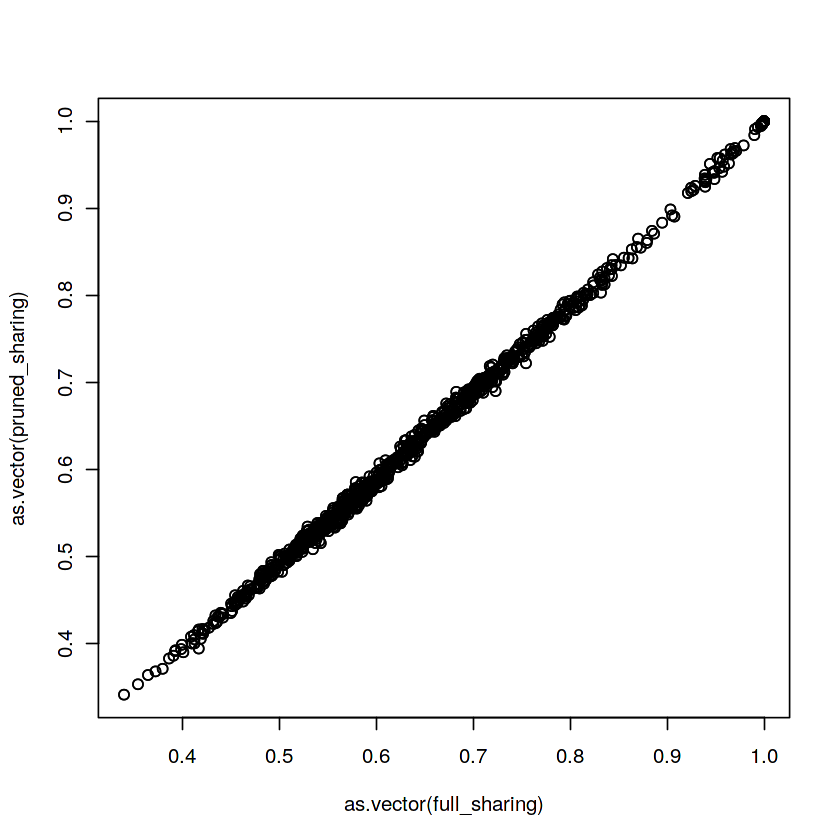

In [8]:
plot(as.vector(full_sharing), as.vector(pruned_sharing))

So the results do agree.